In [1]:
import sys
sys.path.insert(0, '../src')
sys.path.insert(0, 'src') #for running notebook from project root
import numpy as np
import lds_regression as lr
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
%matplotlib inline

d_latent = lr.transition_mat.shape[0]
d_obs = 100
n_neurons = 100
n_trials = 200
sim_bin = .001
fit_bin = 0.02

s,r,f,W = lr.simulate_system(n_trials, n_neurons, 1, same_traj=True)

In [2]:
def get_performance_averaging(smooth_std, fit_bin):
    smoothed, b = lr.smooth_spikes(s, sim_bin, fit_bin, smooth_std)
    sm_av = [smoothed[:int(n_trials/2)].mean(0)]
    A, pca = lr.fit_system(sm_av, d_latent, fit_bin)
    test_av = [smoothed[int(n_trials/2):].mean(0)]
    p,a = lr.one_step_diff_explained(test_av, A, pca, fit_bin)
    r2 = np.corrcoef(np.concatenate(p).flatten(), np.concatenate(a).flatten())[1,0]**2
    #r2 = r2_score(np.concatenate(p), np.concatenate(a))
    return r2,A,pca

In [3]:
#iterative search for best smoothing parameters and fit bin parameters

r2 = []
smooth_stds = np.arange(0.01, 0.1, 0.01)
fit_bins = np.arange(0.01, 0.1, 0.01)
for smooth_std in smooth_stds:
    smooth_std = np.around(smooth_std, 2)
    r2.append(get_performance_averaging(smooth_std, fit_bin)[0])
    
smooth_std = smooth_stds[np.argmax(r2)]
r2 = []
fit_bins = np.arange(.01, .1, .01)
for fit_bin in fit_bins:
    fit_bin = np.around(fit_bin, 2)
    r2.append(get_performance_averaging(smooth_std, fit_bin)[0])
    
fit_bin = fit_bins[np.argmax(r2)]

In [4]:
r2, A, pca = get_performance_averaging(smooth_std, fit_bin)
def report_values(r2, A, pca):
    print('One step prediction r^2: %f'%r2)
    print('Fitted transition matrix:')
    print(A)
    print('True matrix:')
    print(lr.transition_mat)
    print('\nFitted transition matrix eigenvalues:')
    print(np.linalg.eigvals(A))
    print('True eigenvalues:')
    print(np.linalg.eigvals(lr.transition_mat))
    subspace_corr = np.corrcoef(W.flatten(), pca.components_.T.flatten())[1,0]
    print('True and fitted subspace correlation:%f'%subspace_corr)
    
report_values(r2, A, pca)

One step prediction r^2: 0.945899
Fitted transition matrix:
[[ -1.65966008  15.39648605]
 [-12.08371734   0.18765325]]
True matrix:
[[ -0.625 -20.5  ]
 [ 12.5    -0.625]]

Fitted transition matrix eigenvalues:
[-0.73600342+13.60858713j -0.73600342-13.60858713j]
True eigenvalues:
[-0.625+16.00781059j -0.625-16.00781059j]
True and fitted subspace correlation:0.004445


In [5]:
def get_performance_single_trial(smooth_std, fit_bin):
    s,r,f,W = lr.simulate_system(n_trials, n_neurons, 1)
    smoothed, b = lr.smooth_spikes(s, sim_bin, fit_bin, smooth_std)
    train = smoothed[:int(n_trials/2)]
    A, pca = lr.fit_system(train, d_latent, fit_bin)
    test = smoothed[int(n_trials/2):]
    p,a = lr.one_step_diff_explained(test, A, pca, fit_bin)
    r2 = np.corrcoef(np.concatenate(p).flatten(), np.concatenate(a).flatten())[1,0]**2
    #r2 = r2_score(np.concatenate(a), np.concatenate(p))
    return r2, A, pca

#iterative search for best smoothing parameters and fit bin parameters

r2 = []
smooth_stds = np.arange(0.01, 0.1, 0.01)
fit_bins = np.arange(0.01, 0.1, 0.01)
for smooth_std in smooth_stds:
    smooth_std = np.around(smooth_std, 2)
    r2.append(get_performance_single_trial(smooth_std, fit_bin)[0])
    
smooth_std = smooth_stds[np.argmax(r2)]
r2 = []
fit_bins = np.arange(.01, .1, .01)
for fit_bin in fit_bins:
    fit_bin = np.around(fit_bin, 2)
    r2.append(get_performance_single_trial(smooth_std, fit_bin)[0])
    
fit_bin = fit_bins[np.argmax(r2)]

In [6]:
r2, A, pca = get_performance_single_trial(smooth_std, fit_bin)
report_values(r2, A, pca)

One step prediction r^2: 0.262749
Fitted transition matrix:
[[ -0.82234656 -14.66581002]
 [ 10.11757767  -0.77253079]]
True matrix:
[[ -0.625 -20.5  ]
 [ 12.5    -0.625]]

Fitted transition matrix eigenvalues:
[-0.79743868+12.18120895j -0.79743868-12.18120895j]
True eigenvalues:
[-0.625+16.00781059j -0.625-16.00781059j]
True and fitted subspace correlation:-0.026149


# Linear-Gaussian models

## pylds implementation

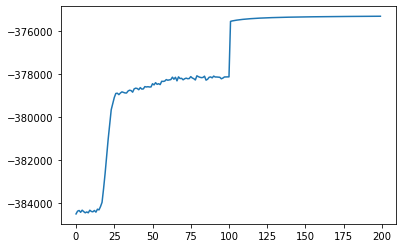

In [7]:
from pylds.models import DefaultLDS

model = DefaultLDS(100, d_latent)
_, b = lr.smooth_spikes(s, sim_bin, fit_bin, smooth_std)
for trial in b: model.add_data(trial)
ll = []
for i in range(100):
    model.resample_model()
    ll.append(model.log_likelihood())
    #print("step %d completed"%i)

for i in range(100):
    model.EM_step()
    ll.append(model.log_likelihood())
    #print("step %d completed"%i)
    
plt.plot(ll)

In [8]:
from evaluate_all_datasets import evaluate_lds_difference

r2, p, a, x = evaluate_lds_difference(b, model)
print(r2)
print(np.corrcoef(np.concatenate(a).flatten(), np.concatenate(p).flatten()))

-4967.010361892623
[[1.         0.13972431]
 [0.13972431 1.        ]]


### Custom implementation
#### Square-root transform

In [9]:
from glds import glds
from evaluate_all_datasets import evaluate_glds

fit_bin = 0.06
smooth_std = 0.06

model = glds(d_obs, d_latent)
smoothed, b = lr.smooth_spikes(s, sim_bin, fit_bin, smooth_std, sqtrans=True)
model.initialize(b)

for i in range(100):
    model.em_step()

In [10]:
from evaluate_all_datasets import evaluate_glds
r2, p, a =  evaluate_glds(b, model)
print(r2)
print(np.corrcoef(np.concatenate(a).flatten(), np.concatenate(p).flatten()))

-9.049136897236286
[[1.         0.15941402]
 [0.15941402 1.        ]]


#### Untransformed

In [13]:
from glds import glds
from evaluate_all_datasets import evaluate_glds

fit_bin = 0.06
smooth_std = 0.06

model = glds(d_obs, d_latent)
smoothed, b = lr.smooth_spikes(s, sim_bin, fit_bin, smooth_std)
model.initialize(b)

for i in range(100):
    model.em_step()

In [12]:
from evaluate_all_datasets import evaluate_glds
r2, p, a =  evaluate_glds(b, model)
print(r2)
print(np.corrcoef(np.concatenate(a).flatten(), np.concatenate(p).flatten()))

-9.050288620660293
[[1.         0.15941063]
 [0.15941063 1.        ]]
